In [1]:
from PIL import Image
from PIL.Image import Resampling
import pylibdmtx.pylibdmtx
import albumentations
import numpy as np
import pandas as pd
import os
import glob
import pathlib
import shutil
import matplotlib.pyplot as plt
from skimage import transform
import json
import sys
import json
import datasets

/home/kp/miniconda3/envs/dm-codes/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Save in format and crop

In [78]:
def save_without_metadata(input_dir: str, output_dir: str, formatter: str = "03d"):
    if not os.path.isdir(input_dir):
        raise ValueError(f'Directory {input_dir} does not exist.')
    
    os.makedirs(output_dir)
    already_copied = 0

    found_files = glob.glob(os.path.join(os.path.abspath(input_dir), "**"))
    found_files.sort()
    
    for file in found_files:
        original_image = Image.open(file)
        data_image = list(original_image.getdata())
        image_without_exif = Image.new(original_image.mode, original_image.size)
        image_without_exif.putdata(data_image)
        image_name = f"{{:{formatter}}}".format(already_copied)
        image_without_exif.save(os.path.abspath(output_dir) + "/" + image_name + ".jpg")
        already_copied += 1

    return already_copied

In [80]:
save_without_metadata(input_dir="../photos/original_photos", output_dir="../photos/without_metadata")

In [74]:
def format_image_json_files(input_dir: str, output_dir: str, formatter: str = "03d"):
    if not os.path.isdir(input_dir):
        raise ValueError(f'Directory {input_dir} does not exist.')
    os.makedirs(output_dir)
    
    found_files = glob.glob(os.path.join(os.path.abspath(input_dir), "*"))
    found_files.sort()
        
    file_names = []
    for num, file in enumerate(found_files):
        file_name = pathlib.Path(file).name
        file_suffix = pathlib.Path(file).suffix
        file_names.append(file_name.removesuffix(file_suffix))
        new_name = f"{{:{formatter}}}".format(num)

        if file_suffix.lower() == ".jpg":
            # delete metadata but keep rotation
            image = Image.fromarray(np.array(Image.open(file)))
            image.save(os.path.abspath(output_dir) + "/" + new_name + ".jpg")
        elif file_suffix == ".json":
            # copy to the output directory    
            shutil.copy(file, os.path.abspath(output_dir) + "/" + new_name + ".json")
        
    return file_names

In [77]:
all_image_files = format_image_json_files(input_dir="../photos/original_photos", output_dir="../photos/formated_photos")
all_json_files = format_image_json_files(input_dir="../photos/jsons", output_dir="../photos/formated_jsons")
print(all_image_files)
print(all_json_files)
assert all_image_files == all_json_files

['IMG_0631', 'IMG_0632', 'IMG_0633', 'IMG_0635', 'IMG_0637', 'IMG_0641', 'IMG_0643', 'IMG_0644', 'IMG_0648', 'IMG_0649', 'IMG_0650', 'IMG_0651', 'IMG_0718', 'IMG_0721', 'IMG_0722', 'IMG_0723', 'IMG_0725', 'IMG_0727', 'IMG_0728', 'IMG_0729', 'IMG_0732', 'IMG_0734', 'IMG_0735', 'IMG_0737', 'IMG_0739', 'IMG_0742', 'IMG_0765', 'IMG_0768', 'IMG_0771', 'IMG_0776', 'IMG_0777', 'IMG_0781', 'IMG_0782', 'IMG_0786', 'IMG_0788', 'IMG_0791', 'IMG_0794', 'IMG_0797', 'IMG_0799', 'IMG_0801', 'IMG_0802', 'IMG_0803', 'IMG_0805', 'IMG_0806', 'IMG_0808', 'IMG_0810', 'IMG_0811', 'IMG_0814', 'IMG_0816', 'IMG_0817', 'IMG_0822', 'IMG_0823', 'IMG_0824', 'IMG_0825', 'IMG_0827', 'IMG_0895', 'IMG_0898', 'IMG_0899', 'IMG_0905', 'IMG_0906', 'IMG_0908', 'IMG_0909', 'IMG_0911', 'IMG_0912', 'IMG_0913', 'IMG_0914', 'IMG_0915', 'IMG_0918', 'IMG_0920', 'IMG_0922', 'IMG_0923', 'IMG_0924', 'IMG_0926', 'IMG_0927', 'IMG_0938', 'IMG_0939', 'IMG_0941', 'IMG_0942', 'IMG_0943', 'IMG_0946', 'IMG_0947', 'IMG_0948', 'IMG_0949', 'IM

In [ ]:
# comment out for git
"""
# plot all annotated images to check that all json annotations are correct

file_dir = "../photos/foo_out"
found_images = glob.glob(os.path.join(os.path.abspath(file_dir), "*.jpg"))
found_images.sort()

for image in found_images:

    dm_code = Image.open(image)
    file_name = pathlib.Path(image).name.removesuffix(".jpg")

    with open(file_dir + "/" + file_name + ".json") as json_file:
        json_data = json.load(json_file)
    vertices = np.asarray(list(json_data.values()))

    # plot annotations
    # 
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.imshow(dm_code, cmap=plt.cm.gray)
    ax.plot(vertices[:, 0], vertices[:, 1], '.r')
    plt.tight_layout()
    plt.show()
"""

In [2]:
def crop_dm_codes(input_dir: str, output_dir_clean: str, output_dir_damaged: str, square_side: int = 200, square_padding: int = 25):
    if not os.path.isdir(input_dir):
        raise ValueError(f'Directory {input_dir} does not exist.')
    os.makedirs(output_dir_clean)
    os.makedirs(output_dir_damaged)
    
    found_images = glob.glob(os.path.join(os.path.abspath(input_dir), "*.jpg"))
    found_images.sort()
    found_jsons = glob.glob(os.path.join(os.path.abspath(input_dir), "*.json"))
    found_jsons.sort()

    assert len(found_images) == len(found_jsons)

    for i in range(len(found_images)):
        dm_code = Image.open(found_images[i])
        with open(found_jsons[i]) as json_file:
            json_data = json.load(json_file)
        vertices = np.asarray((json_data["tl"], json_data["tr"], json_data["br"], json_data["bl"]))
        is_clean = json_data["clean"]

        unit_square = np.asarray([
            [square_padding, square_padding],
            [square_side + square_padding, square_padding],
            [square_side + square_padding, square_side + square_padding],
            [square_padding, square_side + square_padding]])
        
        transf = transform.ProjectiveTransform()
        if not transf.estimate(unit_square, vertices): raise Exception("estimate failed")
        cropped_np_image = transform.warp(np.array(dm_code), transf, output_shape=(square_side + square_padding * 2, square_side + square_padding * 2))

        cropped_image = Image.fromarray((cropped_np_image * 255).astype(np.uint8))
        image_name = pathlib.Path(found_images[i]).name
        if is_clean:
            output_dir = output_dir_clean
        else:
            output_dir = output_dir_damaged
        cropped_image.save(os.path.abspath(output_dir) + "/" + image_name)

In [22]:
crop_dm_codes(input_dir="../photos/formated_photo_json", output_dir_clean="../photos/cropped_clean", output_dir_damaged="../photos/cropped_damaged")

In [24]:
def add_text_to_json(file_dir: str, control_clean_dir: str, square_side: int = 200, square_padding: int = 25):
    if not os.path.isdir(file_dir):
        raise ValueError(f'Directory {file_dir} does not exist.')
    os.makedirs(control_clean_dir)
    
    # find image and json files
    found_images = glob.glob(os.path.join(os.path.abspath(file_dir), "*.jpg"))
    found_images.sort()
    found_jsons = glob.glob(os.path.join(os.path.abspath(file_dir), "*.json"))
    found_jsons.sort()
    assert len(found_images) == len(found_jsons)

    text = ""
    for i in range(len(found_images)):
        # read json file
        with open(found_jsons[i]) as json_file:
            json_data = json.load(json_file)
        vertices = np.asarray((json_data["tl"], json_data["tr"], json_data["br"], json_data["bl"]))
        is_clean = json_data["clean"]

        # crop image
        dm_code = Image.open(found_images[i])
        image_name = pathlib.Path(found_images[i]).name.removesuffix(".jpg")
        unit_square = np.asarray([
            [square_padding, square_padding],
            [square_side + square_padding, square_padding],
            [square_side + square_padding, square_side + square_padding],
            [square_padding, square_side + square_padding]])
        transf = transform.ProjectiveTransform()
        if not transf.estimate(unit_square, vertices): raise Exception("estimate failed")
        cropped_np_image = transform.warp(np.array(dm_code), transf, output_shape=(square_side + square_padding * 2, square_side + square_padding * 2))
        cropped_pil_image = Image.fromarray((cropped_np_image * 255).astype(np.uint8))
        cropped_pil_image = cropped_pil_image.convert("L")

        # decode only if is_clean, otherwise text stays the same
        if is_clean:
            decoded_code = pylibdmtx.pylibdmtx.decode(cropped_pil_image)
            if len(decoded_code) == 0:
                text = ""
                print(f"could not read {image_name}.jpg")
            else:
                try:
                    text = decoded_code[0].data.decode("utf8")

                    # save cropped clean and its reconstruction
                    cropped_pil_image.save(os.path.abspath(control_clean_dir) + "/" + image_name + ".jpg")
                    encoded_back = pylibdmtx.pylibdmtx.encode(text.encode('utf8'))
                    reconstructed_img = Image.frombytes('RGB', (encoded_back.width, encoded_back.height), encoded_back.pixels)
                    reconstructed_img = reconstructed_img.resize(cropped_pil_image.size).rotate(90)
                    reconstructed_img.save(os.path.abspath(control_clean_dir) + "/" + image_name + "_reconstructed.jpg")

                except UnicodeDecodeError:
                    text = ""
                    print(f"could not decode to utf8 {image_name}.jpg")

        # add text to json file
        new_record = {"text": text}
        json_data.update(new_record)
        with open(found_jsons[i], "w") as json_file:
            json.dump(json_data, json_file, indent=2)

In [25]:
add_text_to_json(file_dir="../photos/formated_photo_json", control_clean_dir="../photos/control_clean_crops")

could not read 034.jpg
could not read 104.jpg
could not read 175.jpg


# Reconstruct images

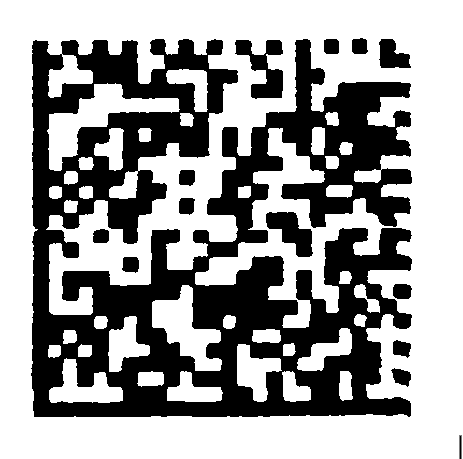

010599700131811921816968741598201725103110F2A01A


In [31]:
dm_code = Image.open(f"../photos/175_clean.png")
display(dm_code)
text = pylibdmtx.pylibdmtx.decode(dm_code)[0].data.decode("utf8")
print(text)

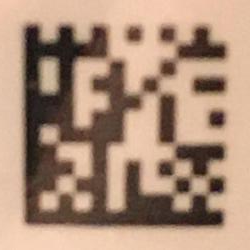

738020


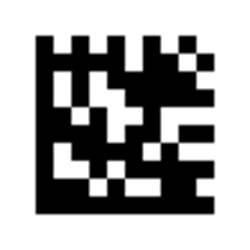

738020


In [27]:
dm_code = Image.open(f"../photos/cropped_clean/030.jpg").rotate(-90)
display(dm_code)
text = pylibdmtx.pylibdmtx.decode(dm_code)[0].data.decode("utf8")
print(text)

encoded = pylibdmtx.pylibdmtx.encode(text.encode('utf8'))
reconstructed_image = Image.frombytes('RGB', (encoded.width, encoded.height), encoded.pixels)
display(reconstructed_image.resize(dm_code.size))

text_again = pylibdmtx.pylibdmtx.decode(reconstructed_image)[0].data.decode("utf8")
print(text_again)

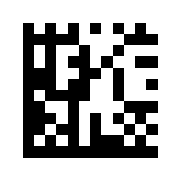

[Decoded(data=b'738020', rect=Rect(left=22, top=22, width=135, height=134), array=array([[55, 55, 55, 55, 48, 48, 48, 48, 55, 55],
        [48, 55, 48, 48, 55, 48, 48, 55, 48, 48],
        [48, 55, 48, 55, 55, 48, 55, 48, 48, 55],
        [55, 55, 48, 48, 55, 55, 48, 55, 48, 48],
        [55, 55, 48, 55, 55, 48, 48, 55, 48, 48],
        [48, 55, 55, 55, 55, 48, 48, 55, 48, 48],
        [55, 48, 48, 55, 48, 48, 48, 48, 55, 55],
        [55, 55, 48, 55, 48, 55, 48, 55, 48, 55],
        [55, 48, 55, 55, 48, 55, 48, 48, 23, 16],
        [48, 55, 48, 55, 48, 55, 55, 55, 16, 23]], dtype=uint8))]

In [5]:
np_030 = np.array([
    [0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1],
    [0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0],
    [0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1],
    [0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0],
    [0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1],
    [0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0],
    [0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1],
    [0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0],
    [0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1],
    [0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0],
    [0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
], dtype="uint8")
np_030 = np_030 * 255
np_030_padded = np.pad(np_030, 2, mode='constant', constant_values=255)

img_reconstructed = Image.fromarray(np_030_padded, mode="L").resize(size=(180,180), resample=Resampling.NEAREST)
display(img_reconstructed)
pylibdmtx.pylibdmtx.decode(img_reconstructed)

In [3]:
def add_dm_border(arr: np.ndarray) -> np.ndarray:
    arr_dm = np.zeros((arr.shape[0] + 2, arr.shape[1] + 2), dtype=arr.dtype)
    arr_dm[1:-1, 1:-1] = arr
    if arr.dtype == np.uint8:
        white = 255
    else:
        white = 1
    arr_dm[0,1::2] = white
    arr_dm[0::2,-1] = white
    return arr_dm

In [ ]:
decoded_img = pylibdmtx.pylibdmtx.decode(img_reconstructed)[0]
dm_array = add_dm_border(decoded_img.array == 48)
dm_array = np.pad(dm_array, 2, mode='constant', constant_values=255)
dm_img = Image.fromarray(dm_array).resize((200, 200), Image.NEAREST).convert('RGB')
dm_img

030


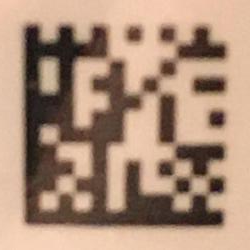

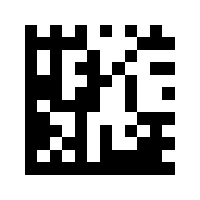

In [5]:
img_name = "030"
print(img_name)
img = Image.open(f"../photos/cropped_clean/{img_name}.jpg")
display(img.rotate(-90))
decoded = pylibdmtx.pylibdmtx.decode(img)[0]
dm_array = add_dm_border(decoded.array == 48)
dm_array = np.pad(dm_array, 2, mode='constant', constant_values=255)
dm_img = Image.fromarray(dm_array).resize((200, 200), Image.NEAREST).convert('RGB')
dm_img

# Prepare for Hugging Face

In [84]:
def create_jsonl(directory: str):
    if not os.path.isdir(directory):
        raise ValueError(f'Directory {directory} does not exist.')

    found_jsons = glob.glob(os.path.join(os.path.abspath(directory), "*.json"))
    found_jsons.sort()
    json_list=[]

    for found_json in found_jsons:
        file_name = pathlib.Path(found_json).name
        file_name = file_name.removesuffix(".json")
        with open(found_json) as json_file:
            json_data = json.load(json_file)
            json_data["file_name"] = file_name + ".jpg"
            json_data = {"file_name": json_data["file_name"]} | json_data
            json_list.append(json_data)

    with open(os.path.join(directory, "metadata.jsonl"), 'w') as output_file:
        for json_data in json_list:
            json.dump(json_data, output_file)
            output_file.write('\n')

In [85]:
create_jsonl(directory = "../photos/formated_photo_json")

In [18]:
test_dataset = datasets.load_dataset("imagefolder", data_dir="../real_test_dataset")["test"]

Resolving data files: 100%|██████████| 201/201 [00:00<00:00, 182203.39it/s]


In [24]:
test_dataset[0]

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=4032x3024>,
 'tl': [1632, 884],
 'tr': [2646, 873],
 'br': [2652, 1896],
 'bl': [1632, 1908],
 'clean': True,
 'text': '11505771-01'}

In [4]:
test_dataset_from_hf = datasets.load_dataset("shortery/dm-codes")

Generating test split: 100%|██████████| 200/200 [00:00<00:00, 428.71 examples/s]


In [7]:
test_dataset_from_hf

DatasetDict({
    test: Dataset({
        features: ['image', 'tl', 'tr', 'br', 'bl', 'clean', 'text'],
        num_rows: 200
    })
})

In [6]:
test_dataset_from_hf["test"][0]

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=4032x3024>,
 'tl': [1632, 884],
 'tr': [2646, 873],
 'br': [2652, 1896],
 'bl': [1632, 1908],
 'clean': True,
 'text': '11505771-01'}

# Cropped dataset for Hugging Face

In [11]:
def create_cropped_damaged_dm_codes_with_jsonl(input_dir: str, output_dir_damaged: str, square_side: int = 200, square_padding: int = 25):
    if not os.path.isdir(input_dir):
        raise ValueError(f'Directory {input_dir} does not exist.')
    os.makedirs(output_dir_damaged)
    
    found_images = glob.glob(os.path.join(os.path.abspath(input_dir), "*.jpg"))
    found_images.sort()
    found_jsons = glob.glob(os.path.join(os.path.abspath(input_dir), "*.json"))
    found_jsons.sort()
    json_list=[]

    assert len(found_images) == len(found_jsons)

    for i, found_json in enumerate(found_jsons):
        dm_code = Image.open(found_images[i])
        with open(found_json) as json_file:
            json_data = json.load(json_file)
        vertices = np.asarray((json_data["tl"], json_data["tr"], json_data["br"], json_data["bl"]))
        is_clean = json_data["clean"]

        if not is_clean:
            unit_square = np.asarray([
                [square_padding, square_padding],
                [square_side + square_padding, square_padding],
                [square_side + square_padding, square_side + square_padding],
                [square_padding, square_side + square_padding]])
            
            transf = transform.ProjectiveTransform()
            if not transf.estimate(unit_square, vertices): raise Exception("estimate failed")
            cropped_np_image = transform.warp(np.array(dm_code), transf, output_shape=(square_side + square_padding * 2, square_side + square_padding * 2))
            cropped_image = Image.fromarray((cropped_np_image * 255).astype(np.uint8))

            file_name = pathlib.Path(found_json).name
            file_name = file_name.removesuffix(".json")
            cropped_image.save(os.path.abspath(output_dir_damaged) + "/" + file_name + ".jpg")
            json_data["file_name"] = file_name + ".jpg"
            json_data = {"file_name": json_data["file_name"]} | json_data
            json_list.append(json_data)

            
    with open(os.path.join(output_dir_damaged, "metadata.jsonl"), 'w') as output_file:
        for json_data in json_list:
            json.dump(json_data, output_file)
            output_file.write('\n')

In [12]:
create_cropped_damaged_dm_codes_with_jsonl(input_dir="../photos/formated_photo_json", output_dir_damaged="../cropped_real_test_dataset/test")

In [13]:
test_cropped_dataset_from_hf = datasets.load_dataset("shortery/cropped-dm-codes")

Resolving data files: 100%|██████████| 163/163 [00:01<00:00, 154.40it/s]
Generating test split: 162 examples [00:00, 2593.91 examples/s]


In [16]:
test_cropped_dataset_from_hf["test"][0]

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=250x250>,
 'tl': [1869, 1737],
 'tr': [2430, 993],
 'br': [3183, 1542],
 'bl': [2604, 2262],
 'clean': False,
 'text': '11505771-01'}